# Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
from pandas_datareader import data, wb
import pandas_datareader
import pandas_ta as ta
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report

from matplotlib.colors import ListedColormap

%pylab inline
%matplotlib inline
warnings.simplefilter('ignore')
plt.style.use('seaborn')
import cufflinks as cf
cf.set_config_file(offline=True)

#customized files
from technical_indicators import *
from utils import *
from prep_data import AssetData

Populating the interactive namespace from numpy and matplotlib


# Data Preparation

The data preparation has been wrapped into *class AssetData* in prep_data.py, here we select 2 equity for the analysis. XLNX and TXN. 10 years' daily records are retrieved to construct the train-test dataset, the wrapper class also support the binary features to simply set if_bin = True.

<font color='red'>**Important:**</font>

**The class AssetData in prep_data has implemented the functionalities (with default parameters):**

    1. download data and prepare the features -> AssetData.df
    2. train test split data -> AssetData.X_train, AssetData.X_test, AssetData.y_train AssetData.y_test
    3. wrap all models' fit procedure -> AssetData.clf_dict (*datatype dict()*)
    4. wrap all models' predict output -> AssetData.y_train_predict, AssetData.y_test_predict (*datatype DataFrame*)
    4. wrap all models'(except SVM) predict_proba output -> AssetData.y_test_predict_proba_test (*datatype dict*)
    5. wrap all models' metrics output required in the assignment -> AssetData.train_confusion_matrix_dict, AssetData.test_confusion_matrix_dict (*datatype dict*) 
    5. wrap all models' AUC plot charts required in the assignment -> AssetData.train_auc_plot_dict, test_auc_plot_dict (*datatype list of plt object*)

**<font color='red'>Notice</font>: prep_data.py**
* For the train test split, parameters are set nonshuffle and 0.2 test size, 2 arguments are not included in the __init__()

* The parameter *base_symbol = '^GSPC'* is not used at the moment, I was thinking to add Index-lagged features to the dataset, but found out the result metrics are not well expected. The related code line 197 is commented out.


All the results of functionalities are the attributes of instantied object (via staticmethod), the benefits is **all outputs can be generated in one run - AssetData.__init__**. 

However, **for the purpose of demo the procedure in this assignment**, the code for task A/B shows explicitly in procedure in this jupyter notebook. 

The Study requirement to choose 2 equities to analyze can simply call the following snippet, **all required output are stored in dictionary assets**

In [2]:
assets = {}
symbol_lst = ['XLNX', 'TXN']
for symbol in symbol_lst:
    assets[symbol] = AssetData(symbol, start_date='2010-01-10', \
                               end_date='2020-01-10', if_bin=False, \
                               y_column = 'direction', y_return = 'return')
assets

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


{'XLNX': <prep_data.AssetData at 0x28e1f2f18c8>,
 'TXN': <prep_data.AssetData at 0x28e205c3788>}

In [3]:
#check the XLNX dataset
print(assets['XLNX'].symbol)
assets['XLNX'].df.head(3)

XLNX


,mom5_lag_1,std5_lag_1,ma5_lag_1,ewma5_lag_1,mom13_lag_1,std13_lag_1,ma13_lag_1,ewma13_lag_1,mom34_lag_1,std34_lag_1,...,return_lag_3,return_lag_4,return_lag_5,return_lag_6,return_lag_7,change_open_lag_1,change_high_lag_1,change_low_lag_1,label_return,label_direction
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-07,0.003215,0.024821,24.642,24.743479,0.007264,0.023665,24.296154,24.589392,-0.092033,0.022816,...,0.031304,-0.022752,-0.017434,0.045219,0.001684,0.009685,0.003909,0.006873,-0.027210,0
2010-06-08,-0.006544,0.026899,24.610,24.592320,0.009559,0.023432,24.313846,24.546622,-0.108951,0.023180,...,0.023248,0.031304,-0.022752,-0.017434,0.045219,0.005607,-0.012959,-0.025297,-0.005780,0
2010-06-09,0.010460,0.024479,24.660,24.444880,-0.004124,0.023391,24.306154,24.489962,-0.125634,0.022998,...,-0.011156,0.023248,0.031304,-0.022752,-0.017434,-0.026711,-0.037041,-0.030630,-0.015019,0


In [4]:
#check the TXN dataset
print(assets['TXN'].symbol)
assets['TXN'].df.head(3)

TXN


,mom5_lag_1,std5_lag_1,mom13_lag_1,std13_lag_1,mom34_lag_1,std34_lag_1,mom55_lag_1,std55_lag_1,mom100_lag_1,std100_lag_1,...,return_lag_3,return_lag_4,return_lag_5,return_lag_6,return_lag_7,change_open_lag_1,change_high_lag_1,change_low_lag_1,label_return,label_direction
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-07,-0.026962,0.021155,-0.048780,0.019590,-0.090293,0.020290,-0.029305,0.019494,-0.070000,0.018462,...,0.016698,-0.002871,-0.017455,0.028988,-0.010713,-0.006064,-0.009176,-0.023811,-0.021317,0
2010-06-08,-0.030713,0.021764,-0.035452,0.018052,-0.104427,0.020534,-0.042476,0.019673,-0.049779,0.018088,...,0.011245,0.016698,-0.002871,-0.017455,0.028988,-0.013883,-0.015755,-0.019296,0.008833,1
2010-06-09,-0.019302,0.022821,-0.031237,0.018238,-0.103940,0.020543,-0.019704,0.019621,-0.045564,0.018106,...,-0.034949,0.011245,0.016698,-0.002871,-0.017455,-0.013662,-0.023065,-0.022271,-0.005880,0


# Task A - Predicting Price Direction

Here we select asset XLNX to demo our task

## A.1 Logistic Classifier and Bayesian Classifier

a) Make sure to implement penalised versions of logistic regression and discuss impact on coefficients. Apply and discuss the difference between L1 and L2 cost functions, the impact made on regression coefficients (comparison table recommended).

b) Demonstrate the use of sklearn.model selection for reshuffled samples and k-fold crossvalidation.

The logistic regression can easily implement using sklearn.linear_model.Here we use the defaul hyperparameters.

In [58]:
clf_logit = Pipeline([("scale", StandardScaler()), ("logit", LogisticRegression())])#standardise the pipeline
clf_logit.fit(assets['XLNX'].X_train, assets['XLNX'].y_train)
y_label_Train_logit_pred = clf_logit.predict(assets['XLNX'].X_train)
y_label_Test_logit_pred = clf_logit.predict(assets['XLNX'].X_test)
print('logit classification report (train data):')
print(classification_report(assets['XLNX'].y_train, y_label_Train_logit_pred))
print('logit classification report (test data):')
print(classification_report(assets['XLNX'].y_test, y_label_Test_logit_pred))

logit classification report (train data):
              precision    recall  f1-score   support

           0       0.55      0.28      0.37       908
           1       0.56      0.79      0.65      1024

    accuracy                           0.55      1932
   macro avg       0.55      0.54      0.51      1932
weighted avg       0.55      0.55      0.52      1932

logit classification report (test data):
              precision    recall  f1-score   support

           0       0.50      0.42      0.45       228
           1       0.55      0.62      0.58       256

    accuracy                           0.53       484
   macro avg       0.52      0.52      0.52       484
weighted avg       0.52      0.53      0.52       484



In [63]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
tn, fp, fn, tp = confusion_matrix(assets['XLNX'].y_test, y_label_Test_logit_pred).ravel()
ac = (tp + tn) / (tn + fp + fn + tp)
p, r= tp / (tp + fp), tp / (tp + fn)
f1 = (2 * p * r) / (p + r)
temp_df = pd.DataFrame({'tn':[tn], 'fp':[fp], 'fn':[fn], 'tp':[tp], \
                'accuracy' : [ac], \
                'precision':[p], 'recall':[r], 'f1':[f1]})
temp_df

,tn,fp,fn,tp,accuracy,precision,recall,f1
0,95,133,96,160,0.52686,0.546075,0.625,0.582878


In [64]:
confusion_matrix(assets['XLNX'].y_test, y_label_Test_logit_pred)

array([[ 95, 133],
       [ 96, 160]], dtype=int64)

The naive bayes classifier can easily implement using sklearn.naive_bayes.

In [5]:
clf_nb = Pipeline([("scale", StandardScaler()), ("naive_bayes ", GaussianNB())]) #standardise the pipeline, placeholder for StandardScaler
print(clf_nb)
clf_nb.fit(assets['XLNX'].X_train, assets['XLNX'].y_train)
y_label_Train_nb_pred = clf_nb.predict(assets['XLNX'].X_train)
y_label_Test_nb_pred = clf_nb.predict(assets['XLNX'].X_test)
print('naive bayes classification report (train data):')
print(classification_report(assets['XLNX'].y_train, y_label_Train_nb_pred))
print('naive bayes classification report (test data):')
print(classification_report(assets['XLNX'].y_test, y_label_Test_nb_pred))

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('naive_bayes ', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)
naive bayes classification report (train data):
              precision    recall  f1-score   support

           0       0.49      0.72      0.58       908
           1       0.56      0.32      0.41      1024

    accuracy                           0.51      1932
   macro avg       0.52      0.52      0.50      1932
weighted avg       0.53      0.51      0.49      1932

naive bayes classification report (test data):
              precision    recall  f1-score   support

           0       0.47      0.75      0.58       228
           1       0.54      0.26      0.35       256

    accuracy                           0.49       484
   macro avg       0.50      0.50      0.47       484
weighted avg       0.51      0.49      0.46       484



In [6]:
classification_report(assets['XLNX'].y_train, y_label_Train_logit_pred, output_dict=True)
classification_report_dict = {}
classification_report_dict['classifier'] = ['logit', 'logit', 'naive_bayes', 'naive_bayes']
classification_report_dict['train or test'] = ['train', 'test', 'train', 'test']
for metric in ['accuracy']:
    classification_report_dict[metric] = [classification_report(assets['XLNX'].y_train, y_label_Train_logit_pred, output_dict=True)[metric],\
                                          classification_report(assets['XLNX'].y_test, y_label_Test_logit_pred, output_dict=True)[metric],\
                                          classification_report(assets['XLNX'].y_train, y_label_Train_nb_pred, output_dict=True)[metric],\
                                          classification_report(assets['XLNX'].y_test, y_label_Test_nb_pred, output_dict=True)[metric]]
for metric in ['precision', 'recall', 'f1-score']:
    classification_report_dict[metric] = [classification_report(assets['XLNX'].y_train, y_label_Train_logit_pred, output_dict=True)['weighted avg'][metric],\
                                          classification_report(assets['XLNX'].y_test, y_label_Test_logit_pred, output_dict=True)['weighted avg'][metric],\
                                          classification_report(assets['XLNX'].y_train, y_label_Train_nb_pred, output_dict=True)['weighted avg'][metric],\
                                          classification_report(assets['XLNX'].y_test, y_label_Test_nb_pred, output_dict=True)['weighted avg'][metric]]
pd.DataFrame.from_dict(classification_report_dict)

,classifier,train or test,accuracy,precision,recall,f1-score
0,logit,train,0.553830,0.552422,0.553830,0.521947
1,logit,test,0.526860,0.523137,0.526860,0.521913
2,naive_bayes,train,0.509317,0.527259,0.509317,0.490458
3,naive_bayes,test,0.489669,0.506576,0.489669,0.458880


Given the features and label data, The logistic regression and naive bayes is applied. The trains-tests split is based on sequential. The accuracy scores of the models for the training and test data are around 50%. For the accuracy metric of **the given equity**, the logit classifier overall performs a little bit better than naive bayes classifier (**0.55 vs 0.51** on training data and **0.52 vs 0.48** on testing data).

### A.1a The difference between L1 and L2 cost functions, and the impact made on regression coefficients

Below is the table of different combinations of pentaly and C, with the comparsion on coefficients' sparsity, train accuracy score, and test accuracy score.

In [7]:
clf_logit_dict = {'penalty':list(), 'C':list(), 'logit model':list(), 'coef':list(), 
                  'sparsity': list(), 'train score':list(), 'test score':list()}
for penalty in ['l1', 'l2']:
    for i, C in enumerate([10**i for i in range(-3, 3)]):
        clf_logit = LogisticRegression(penalty=penalty, C=C)
        clf_logit.fit(assets['XLNX'].X_train, assets['XLNX'].y_train)
        clf_logit_dict['penalty'].append(penalty)
        clf_logit_dict['C'].append(C)
        clf_logit_dict['logit model'].append(clf_logit)
        clf_logit_dict['coef'].append(clf_logit.coef_.ravel())
        clf_logit_dict['sparsity'].append(np.mean(clf_logit.coef_ == 0) * 100)
        clf_logit_dict['train score'].append(clf_logit.score(assets['XLNX'].X_train, assets['XLNX'].y_train))
        clf_logit_dict['test score'].append(clf_logit.score(assets['XLNX'].X_test, assets['XLNX'].y_test))
df_clf_logit = pd.DataFrame.from_dict(clf_logit_dict)
df_clf_logit

,penalty,C,logit model,coef,sparsity,train score,test score
0,l1,0.001,"LogisticRegression(C=0.001, class_weight=None,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",96.666667,0.530021,0.528926
1,l1,0.010,"LogisticRegression(C=0.01, class_weight=None, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",96.666667,0.530021,0.528926
2,l1,0.100,"LogisticRegression(C=0.1, class_weight=None, d...","[0.0, 0.0, 0.0, -0.00940644242361699, 0.0, 0.0...",90.000000,0.531573,0.506198
3,l1,1.000,"LogisticRegression(C=1, class_weight=None, dua...","[0.0, 0.0, 0.0, -0.018182223675892253, 0.0, 0....",80.000000,0.530538,0.502066
4,l1,10.000,"LogisticRegression(C=10, class_weight=None, du...","[-0.5312790120158976, 6.915320479237322, 0.047...",20.000000,0.545549,0.500000
5,l1,100.000,"LogisticRegression(C=100, class_weight=None, d...","[-0.8451542736736208, 16.715395354698757, 0.06...",3.333333,0.541925,0.528926
6,l2,0.001,"LogisticRegression(C=0.001, class_weight=None,...","[-0.0004961627609148724, 0.0002427868660268225...",0.000000,0.530021,0.504132
7,l2,0.010,"LogisticRegression(C=0.01, class_weight=None, ...","[-0.004699357939809089, 0.002112678020716196, ...",0.000000,0.532609,0.500000
8,l2,0.100,"LogisticRegression(C=0.1, class_weight=None, d...","[-0.04050023553000733, 0.018300958056034544, 0...",0.000000,0.533126,0.497934
9,l2,1.000,"LogisticRegression(C=1, class_weight=None, dua...","[-0.2820459456718455, 0.1621112795842738, 0.05...",0.000000,0.537267,0.510331


Specifically, here check the varing coefficients of logit classifiers by fixing $L2$ cost function 

In [8]:
for i, column in enumerate(assets['XLNX'].X.columns):
    df_clf_logit[column] = df_clf_logit['coef'].apply(lambda x : x[i])
df_clf_logit_coef = df_clf_logit[df_clf_logit['penalty']=='l2'].set_index('C')[assets['XLNX'].X.columns]
df_clf_logit_coef

,mom5_lag_1,std5_lag_1,ma5_lag_1,ewma5_lag_1,mom13_lag_1,std13_lag_1,ma13_lag_1,ewma13_lag_1,mom34_lag_1,std34_lag_1,...,return_lag_1,return_lag_2,return_lag_3,return_lag_4,return_lag_5,return_lag_6,return_lag_7,change_open_lag_1,change_high_lag_1,change_low_lag_1
C,,,,,,,,,,,,,,,,,,,,,
0.001,-0.000496,0.000243,-0.003413,-0.004720,-0.000915,-0.000058,-0.002403,-0.002265,-0.000081,0.000005,...,-0.000483,0.000155,0.000136,-0.000029,-0.000296,0.000356,-0.000279,0.000199,-0.000209,0.000012
0.010,-0.004699,0.002113,-0.001866,-0.015396,-0.008563,-0.000982,-0.002394,0.004517,-0.001672,-0.000323,...,-0.004868,0.001626,0.001454,-0.000198,-0.002898,0.003673,-0.002737,0.002046,-0.002086,0.000143
0.100,-0.040500,0.018301,0.030595,-0.055945,-0.068880,-0.013038,-0.028562,0.030472,-0.025755,-0.005035,...,-0.045738,0.018635,0.016370,-0.001367,-0.029984,0.035300,-0.027211,0.022821,-0.018212,0.004054
1.000,-0.282046,0.162111,0.053618,-0.115482,-0.524726,-0.136223,-0.085145,0.185254,-0.184963,-0.053468,...,-0.375440,0.190053,0.170360,-0.003787,-0.277306,0.289680,-0.260646,0.238194,-0.130788,0.077150
10.000,-0.702965,1.449051,0.114649,-0.262566,-1.868380,-1.232672,-0.157349,0.635257,-0.307419,-0.446798,...,-1.724052,0.922463,1.307456,0.160320,-1.495724,1.217365,-1.563479,1.582087,-0.470802,1.075667
100.000,0.178731,5.765955,0.390702,-0.733873,-3.392152,-5.390316,-0.165473,1.404436,0.344732,-1.742045,...,-3.226135,1.923757,3.929696,0.731622,-3.724859,1.532400,-3.023811,2.974663,-0.995247,3.420761


In [10]:
df_clf_logit_coef.sort_index(ascending=False).iplot(subplots=True, kind='line', logx = True, vertical_spacing = 0.02)

As we can observe from the table and plot, the regularization (1/C) leads to smaller coefficients, the l1 penalty can result in sparse coefficient. Further, the Regularization can lead to better performance. As show below, the model with highest accuracy score uses $C = 10e2$.

In [10]:
df_clf_logit_best_estimator = df_clf_logit[df_clf_logit['test score'] == df_clf_logit['test score'].max()]\
[['penalty', 'C', 'logit model', 'coef', 'sparsity', 'train score', 'test score']]
df_clf_logit_best_estimator

,penalty,C,logit model,coef,sparsity,train score,test score
0,l1,0.001,"LogisticRegression(C=0.001, class_weight=None,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",96.666667,0.530021,0.528926
1,l1,0.010,"LogisticRegression(C=0.01, class_weight=None, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",96.666667,0.530021,0.528926
5,l1,100.000,"LogisticRegression(C=100, class_weight=None, d...","[-0.8451542736736208, 16.715395354698757, 0.06...",3.333333,0.541925,0.528926


### A.1b K-Fold CV in Finance time-series

Although we know that shuffling the timeseries data before k-fold cv is not proposed because of the data leakage. Here's we still compare the 10-fold plot performance between non-shuffled and shuffled data.

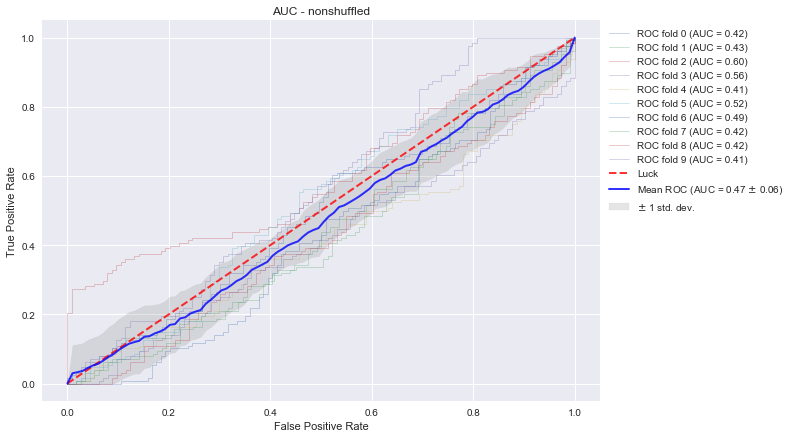

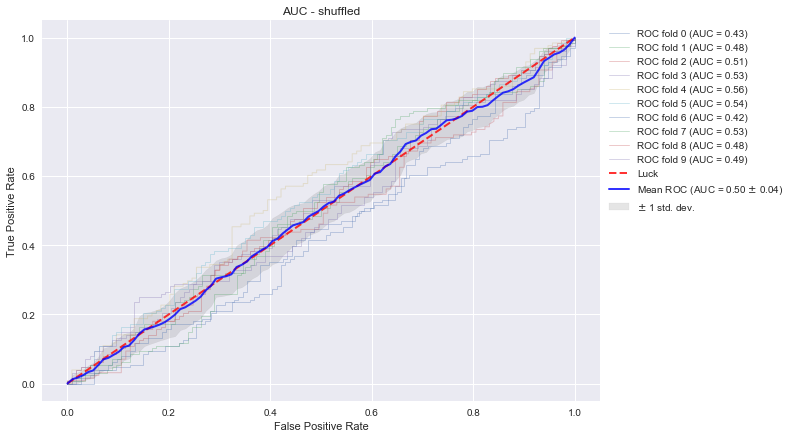

In [11]:
from utils import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection._split import StratifiedKFold
classifier = df_clf_logit_best_estimator['logit model'].iloc[0]
#l1, 0.1
kfold_nonshuffled = StratifiedKFold(n_splits=10, shuffle=False, random_state=0)
crossValPlot(kfold_nonshuffled,classifier,assets['XLNX'].X, assets['XLNX'].y, title = 'AUC - nonshuffled')
kfold_shuffled = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
crossValPlot(kfold_shuffled,classifier,assets['XLNX'].X, assets['XLNX'].y, title = 'AUC - shuffled')

### A.1b Why K-fold CV fails in finance time-series

k-fold CV fails in finance is because observations cannot be assumed to be drawn from an IID process. When autocorrelated data is shuffled information is leaked into the training set and increases the risks of overfitting. Given the concerns of leakage, one trade-off solution was proposed using purged K-fold cross validation.

## A.2 Support Vector Machines

a) Consider soft vs. hard margin, present in mathematical notation and consider impact on your 2D relationships. 

b) Specifically consider Momentum Feature vs Return t - 1 and provide 2D visualisation (up/down points in different colour). While support vectors are difficult to present, use *SVM_SVC.supportvectors* and prepare interpretable visualisations. 

c) No need to vary type of kernel.

In [12]:
clf_svc = Pipeline([("scale", StandardScaler()), ("svc", SVC(C=5, kernel='linear'))])
clf_svc.fit(assets['XLNX'].X_train, assets['XLNX'].y_train)
y_label_Train_svc_pred = clf_logit.predict(assets['XLNX'].X_train)
y_label_Test_svc_pred = clf_logit.predict(assets['XLNX'].X_test)
print(classification_report(assets['XLNX'].y_train, y_label_Train_svc_pred))
print(classification_report(assets['XLNX'].y_test, y_label_Test_svc_pred))

              precision    recall  f1-score   support

           0       0.52      0.27      0.36       908
           1       0.55      0.78      0.64      1024

    accuracy                           0.54      1932
   macro avg       0.53      0.53      0.50      1932
weighted avg       0.53      0.54      0.51      1932

              precision    recall  f1-score   support

           0       0.46      0.34      0.39       228
           1       0.53      0.65      0.58       256

    accuracy                           0.50       484
   macro avg       0.49      0.50      0.49       484
weighted avg       0.50      0.50      0.49       484



### A.2a Hard margin vs Soft margin

The SVM classifier is to find that separating hyperplane in th middle of your dataset. 

Given the train data $(\vec x_1, y_1) ... (\vec x_n, y_n)$ where $y_i = \{+1, -1\}$. We want to find the "maximum-margin hyperplane" that divides the group of points ${\vec x_i}$ for which ${\displaystyle y_{i}=1}$ from the group of points for which ${\displaystyle y_{i}=-1}$,  which is defined so that the distance between the hyperplane and the nearest point ${\displaystyle {\vec {x}}_{i}}$ from either group is maximized.

##### Hard margin

The objective function of a hard-margin svm is to:
$$min||\vec w||$$ subject to $$y_i({\vec w} \cdot {\vec x_i} - b) \geq 1 \space for \space i = 1 ... n$$

Consider a simple 2D features dataset cases.

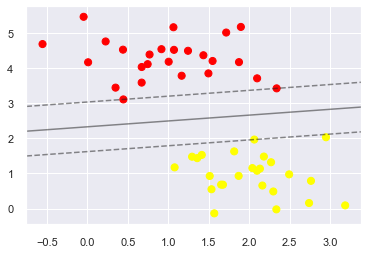

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# use seaborn plotting defaults
import seaborn as sns; sns.set()
from sklearn.datasets import samples_generator
X, y = samples_generator.make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)
plot_svc_decision_function(model, plot_support=True);

##### Soft margin

Hard margin SVM can work only when data is completely linearly separable. And to extend SVM to cases in which the data are not linearly separable, we introduce the function. $$J = \frac{1}{N} \sum_{n=1}^{N} max(0,1 - y_i({\vec w} \cdot {\vec x_i} - b)) + \lambda |{\vec w}|^2$$

Where $\lambda$ is the trade between the margin size and whether or not the data lies on the corrct side of the margin. Thus, for sufficiently small values of $\lambda$ ($\lambda = 1/C$), the second term in the loss function will become negligible, and it'll behave like a hard margin svm. $\lambda$ is one of the of regularization technique.

Consider a simple 2D features dataset cases.

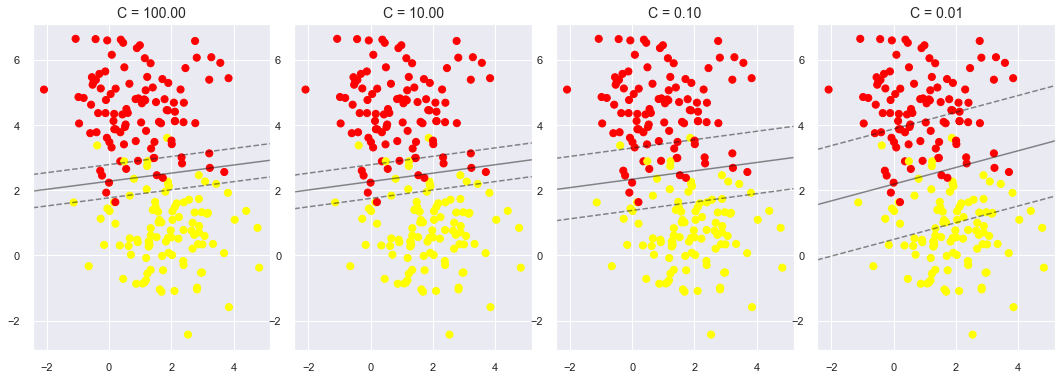

In [16]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=200, centers=2,
                  random_state=0, cluster_std=1.2)
fig, ax = plt.subplots(1, 4, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [100, 10.0, 0.1, 0.01]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.2f}'.format(C), size=14)

### A.2b 2D features' decision plot

Choose features ['mom5_lag_1', 'return_lag_1'] for the 2d features' svc.

In [13]:
import matplotlib.pyplot as plt
pd.DataFrame({'feature_name': list(assets['XLNX'].X_train.columns), \
              'feature_importance':clf_svc['svc'].coef_[0].tolist()}).set_index('feature_name').iplot(kind='barh')

By fitting 2d X features and y into the SVC model, check the decision boundary by different C

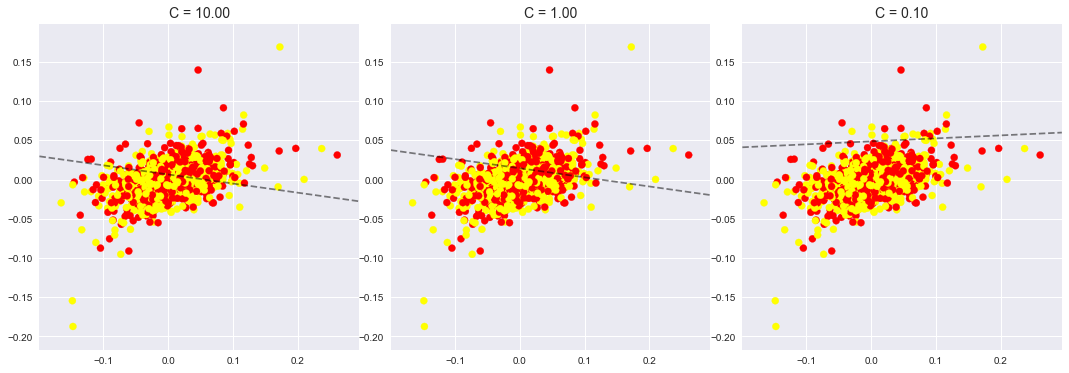

In [18]:
#clf_svc_2d = Pipeline([("scale", StandardScaler()), ("svc", SVC(C=5, kernel='linear'))])
#plt.scatter(assets['XLNX'].X['mom5_lag_1'].values, assets['XLNX'].X['return_lag_1'].values, c=assets['XLNX'].y, s=50, cmap='autumn')
#clf_svc_2d.fit(assets['XLNX'].X[['mom5_lag_1', 'return_lag_1']], assets['XLNX'].y)
features_2d_lst = ['mom5_lag_1', 'return_lag_1']##'return_lag_1', 'ma100_lag_1'
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, C in zip(ax, [10.0, 1, 0.1]):#, 0.01]):
    #model = Pipeline([("scale", StandardScaler()), ("svc", SVC(C=C, kernel='linear'))])
    model = SVC(C=C, kernel='linear')
    model.fit(assets['XLNX'].X[features_2d_lst], assets['XLNX'].y)
    axi.scatter(assets['XLNX'].X[features_2d_lst[0]].values, assets['XLNX'].X[features_2d_lst[1]].values, c=assets['XLNX'].y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.2f}'.format(C), size=14)

## A.3 K-Nearest Neighbours Classifier

a) Given KNN's dependence on distance computation scale the features, eg, *StandardScaler* from *sklearn.preprocessing*. 

b) Report on sensible values for *n_neighbors* hyperparameter and provide comparison of *metric*, particularly Manhattan vs Euclidean vs Mahalanobis - see *DistanceMetric* class. 

c) Plot decision boundaries, if sensible and describe in brief what is 'lazy' about classification with KNN.


take the same 2 features as SVM to form the 2D plot

### A.3b1 Classifier error rate against k values (euclidean_distance)
The knn classifiers are plugined into the pipeline with StandardScaler() for the preprocessing.

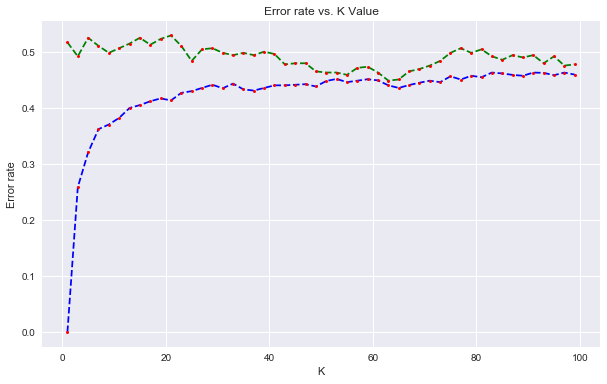

In [71]:
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
train_error_lst, test_error_lst = [], []
p_key = 'euclidean_distance'
for n_neighbors in range(1, 100, 2):
    clf_neighbor = Pipeline([("scale", StandardScaler()), ("KNN", KNeighborsClassifier(n_neighbors = n_neighbors, p = 2))])
    clf_neighbor.fit(assets['XLNX'].X_train, assets['XLNX'].y_train)
    y_label_Train_knn_pred = clf_neighbor.predict(assets['XLNX'].X_train)
    y_label_Test_knn_pred = clf_neighbor.predict(assets['XLNX'].X_test)
    #y_label_Test_knn_pred = clf_neighbor.predict(X_test)
    #sensitivity_lst.append(classification_report(assets['XLNX'].y_train, y_label_Train_knn_pred, output_dict = True)['1']['recall'])
    train_error_lst.append(1-classification_report(assets['XLNX'].y_train, y_label_Train_knn_pred, output_dict = True)['accuracy'])
    test_error_lst.append(1-classification_report(assets['XLNX'].y_test, y_label_Test_knn_pred, output_dict = True)['accuracy'])
plt.figure(figsize=(10,6))
plt.plot(range(1,100,2),train_error_lst,color='blue', linestyle='dashed', marker='o',\
         markerfacecolor='red', markersize=3)
plt.plot(range(1,100,2),test_error_lst,color='green', linestyle='dashed', marker='o',\
         markerfacecolor='red', markersize=3)
plt.title('Error rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error rate')
plt.show()

Here it's a good choice to select the K value with minimal gaps between train error and test error. K = 63, as shown below:

In [78]:
1 + np.argmin([float(a) - float(b) for a, b in zip(test_error_lst, train_error_lst)])*2

63

### A.3b KNN classifiers of metrics (manhattan vs euclidean vs mahalanobis) error rate against k values
The knn classifiers are plugined into the pipeline with StandardScaler() for the preprocessing.

In [87]:
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
p_values = {'manhattan':1, 'euclidean':2, 'mahalanobis':None}
train_error_dict = {}
range_lst = list(range(1, 100, 4))
train_error_dict['K Value'] = range_lst
for p_key, p_value in p_values.items():
    train_error_lst = []
    for n_neighbors in range_lst:
        #print(n_neighbors)
        if p_key == 'mahalanobis':
            clf_neighbor = Pipeline([("scale", StandardScaler()), \
                         ("KNN", KNeighborsClassifier(n_neighbors = n_neighbors, \
                                                      metric='mahalanobis',
                                                      metric_params={'V': np.cov(assets['XLNX'].X_train.T)}))])
        else:
            clf_neighbor = Pipeline([("scale", StandardScaler()), ("KNN", KNeighborsClassifier(n_neighbors = n_neighbors, p = p_value))])
        clf_neighbor.fit(assets['XLNX'].X_train, assets['XLNX'].y_train)
        y_label_Train_knn_pred = clf_neighbor.predict(assets['XLNX'].X_train)
        #sensitivity_lst.append(classification_report(assets['XLNX'].y_train, y_label_Train_knn_pred, output_dict = True)['1']['recall'])
        train_error_lst.append(1-classification_report(assets['XLNX'].y_train, y_label_Train_knn_pred, output_dict = True)['accuracy'])
    train_error_dict[p_key] = train_error_lst
# plt.title('Sensitivity vs. K Value')
# plt.xlabel('K')
# plt.ylabel('Sensitivity')
# plt.show()
pd.DataFrame(train_error_dict).set_index('K Value').iplot(title = 'training error rate plot')

Here we select the optimal k value = 63 to form the KNN classifier

In [81]:
clf_neighbor = Pipeline([("scale", StandardScaler()), ("KNN", KNeighborsClassifier(n_neighbors = 63, p = 2))])
clf_neighbor.fit(assets['XLNX'].X_train, assets['XLNX'].y_train)
y_label_Train_knn_pred = clf_neighbor.predict(assets['XLNX'].X_train)
print(classification_report(assets['XLNX'].y_train, y_label_Train_knn_pred))
print(classification_report(assets['XLNX'].y_test, y_label_Test_knn_pred))

              precision    recall  f1-score   support

           0       0.56      0.32      0.40       908
           1       0.56      0.77      0.65      1024

    accuracy                           0.56      1932
   macro avg       0.56      0.55      0.53      1932
weighted avg       0.56      0.56      0.54      1932

              precision    recall  f1-score   support

           0       0.49      0.46      0.47       228
           1       0.55      0.58      0.56       256

    accuracy                           0.52       484
   macro avg       0.52      0.52      0.52       484
weighted avg       0.52      0.52      0.52       484



### A.3c Plot decision boundaries
Here we use manhattan distance to plot the decision boundaries on 2D features:'mom5_lag_1', 'return_lag_1'

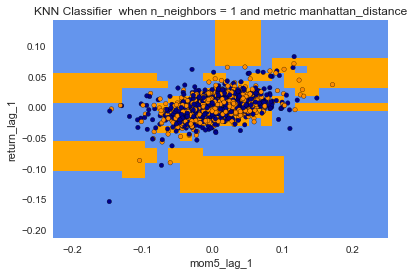

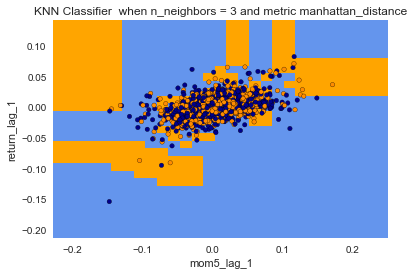

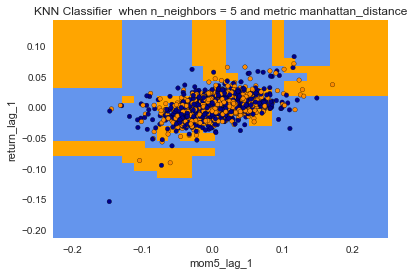

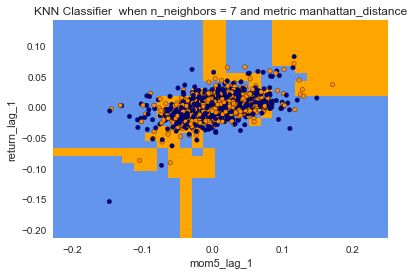

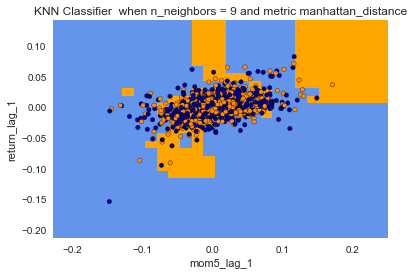

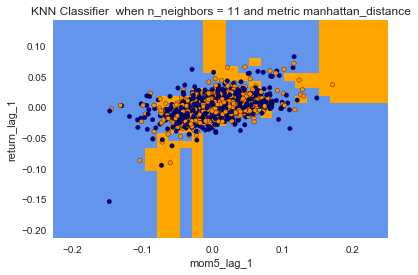

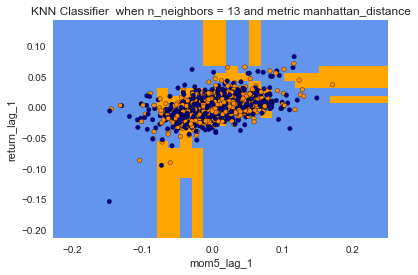

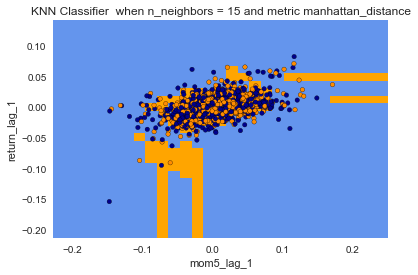

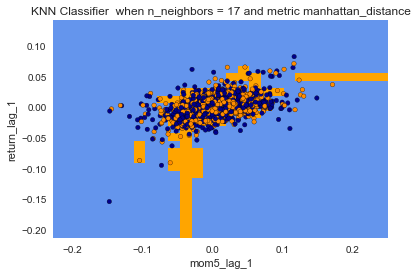

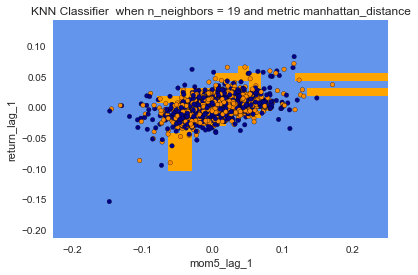

In [31]:
#from utils import plot_knn_decision_function
features_2d_lst = ['mom5_lag_1', 'return_lag_1']
p_values = {'manhattan_distance':1}
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])
for n_neighbors in range(1, 20, 2):
    clf_neighbor2d = Pipeline([("scale", StandardScaler()), ("KNN", KNeighborsClassifier(n_neighbors = n_neighbors, p = p_values['manhattan_distance']))])
    clf_neighbor2d.fit(assets['XLNX'].X_train[features_2d_lst], assets['XLNX'].y_train)
    plot_knn_decision_function(clf_neighbor2d, assets['XLNX'].X_train[features_2d_lst], assets['XLNX'].y_train, n_neighbors, 'manhattan_distance')

KNN algorithms are considered lazy because no abstraction occurs. Duing the fit procedure of KNN, it only store the training data, and there's no discriminative function abstracted from the training data. Therefore, the prediction procedure of KNN is relatively expensive since it searches for the nearest neighbors in th entire training set.

# Task B - Prediction Quality and Bias

## Task B.1 Confusion matrix (precision/recall statistics) and area under ROC curve
Investigate the prediction quality using **confusion matrix** (precision/recall statistics) and **area under ROC curve** - these are possible for all classifiers if prediction is binomial. Particularly check the quality of predicting the down movements (negative sign of return).

Here let's use our instantiated object **assets['XLNX']**:
 - the attribute train_confusion_matrix_dict and test_confusion_matrix_dict for all required metrics
 - the attribute train_auc_plot_dict and test_auc_plot_dict for all AUC plots 

In [7]:
train_cm_dict = assets['XLNX'].train_confusion_matrix_dict
print('metrics of training set')
pd.concat(train_cm_dict.values(), ignore_index=False)

metrics of training set


,tn,fp,fn,tp,precision,recall,f1
model_name,,,,,,,
y_logit,257,651,211,813,0.555328,0.793945,0.653537
y_nb,652,256,692,332,0.564626,0.324219,0.411911
y_svm,395,513,151,873,0.629870,0.852539,0.724481
y_knn,565,343,276,748,0.685610,0.730469,0.707329
y_rf,63,845,13,1011,0.544720,0.987305,0.702083


In [8]:
test_cm_dict = assets['XLNX'].test_confusion_matrix_dict
print('metrics of test set')
pd.concat(test_cm_dict.values(), ignore_index=False)

metrics of test set


,tn,fp,fn,tp,precision,recall,f1
model_name,,,,,,,
y_logit,95,133,96,160,0.546075,0.625000,0.582878
y_nb,170,58,189,67,0.536000,0.261719,0.351706
y_svm,17,211,16,240,0.532151,0.937500,0.678925
y_knn,124,104,150,106,0.504762,0.414062,0.454936
y_rf,150,78,161,95,0.549133,0.371094,0.442890


In [20]:
train_auc_plot_dict = assets['XLNX'].train_auc_plot_dict
test_auc_plot_dict = assets['XLNX'].test_auc_plot_dict

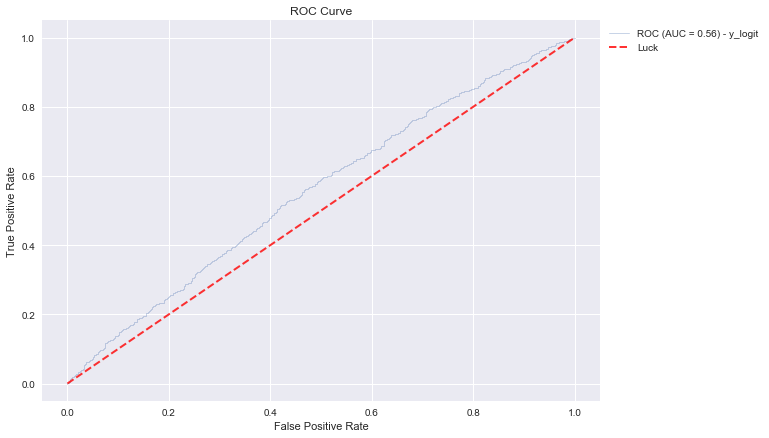

In [25]:
train_auc_plot_dict['y_logit']

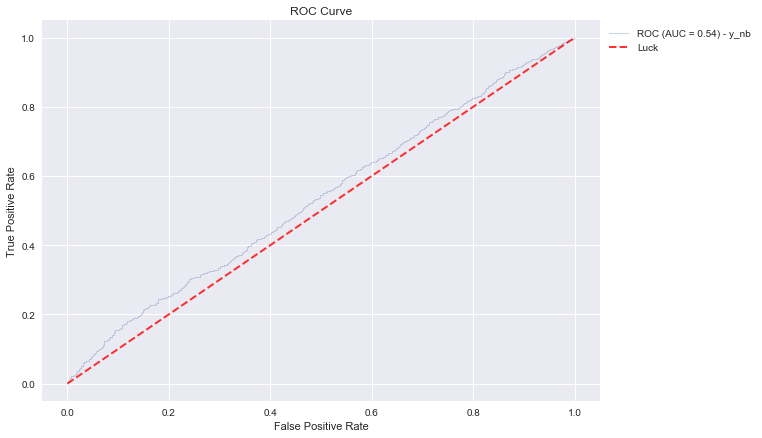

In [29]:
train_auc_plot_dict['y_nb']

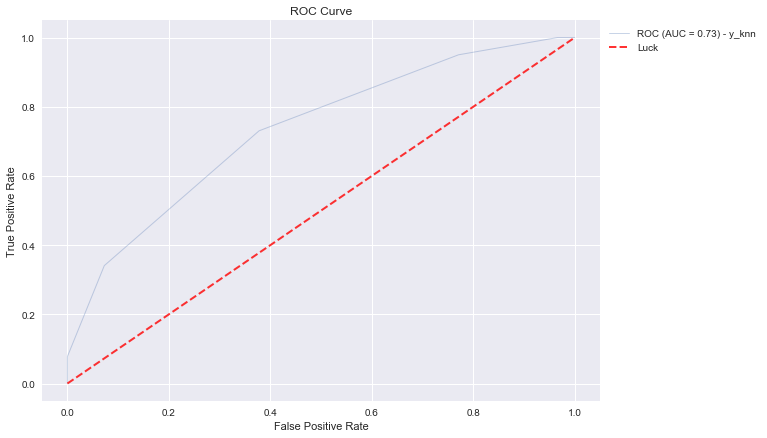

In [27]:
train_auc_plot_dict['y_knn']

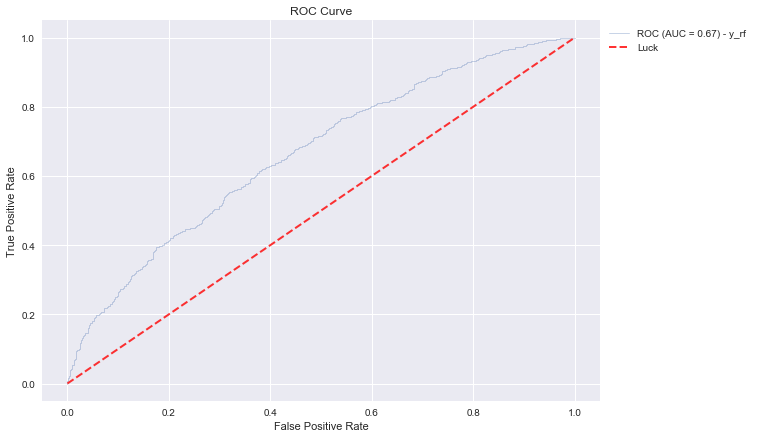

In [26]:
train_auc_plot_dict['y_rf']

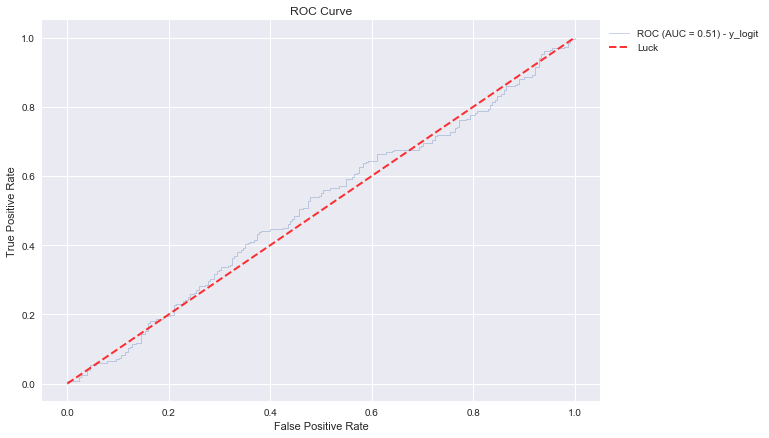

In [32]:
test_auc_plot_dict['y_logit']

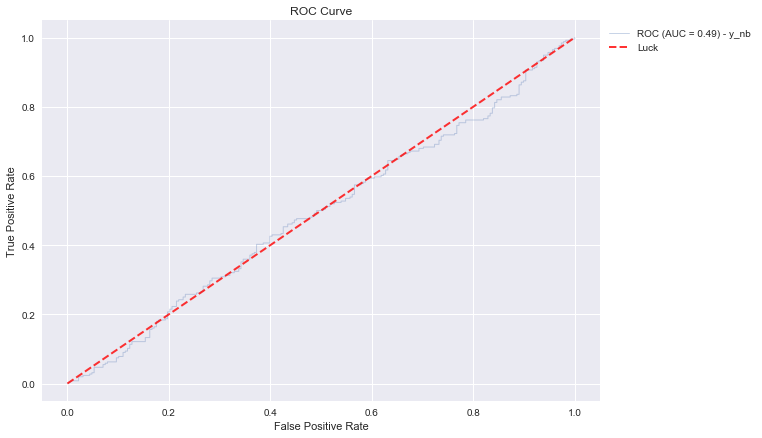

In [35]:
test_auc_plot_dict['y_nb']

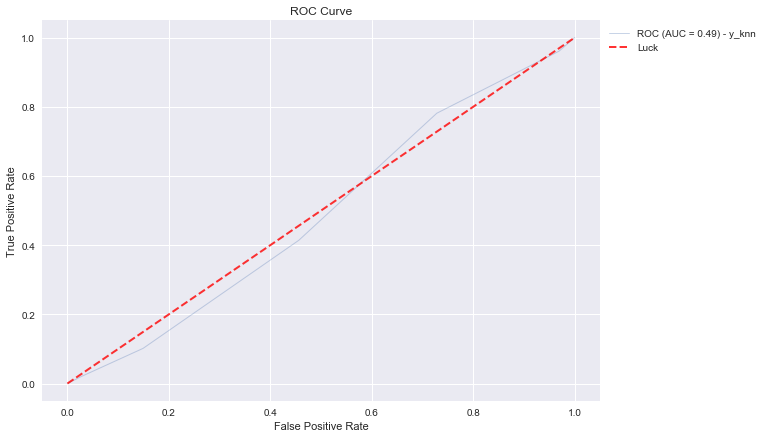

In [33]:
test_auc_plot_dict['y_knn']

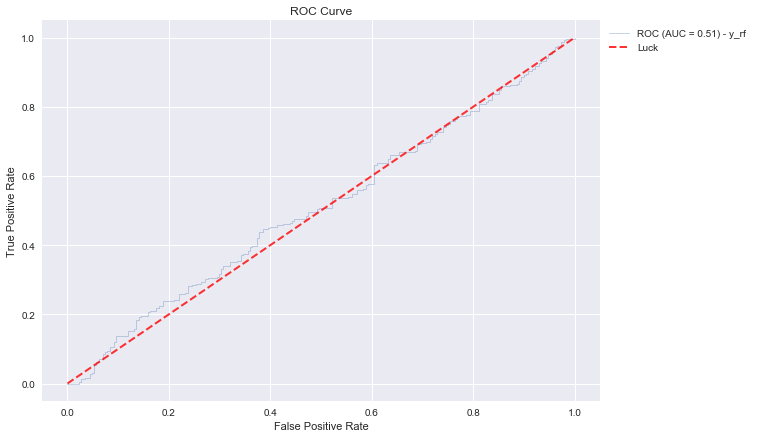

In [34]:
test_auc_plot_dict['y_rf']

## Task B.2 Feature selection and model selection
Attempt feature scoring or selection, for instance with *sklearn.model-selection.GridSearchCV*. Briefly compare results between all-feature/selected features models. Alternatively, introduce bagging and discuss prediction implications and accuracy. Make recommendation on how to reduce **misclassied negative returns**.


2 pipeline objects are constructed, One contains feature selection step (RFECV) and another one doesn't. Both of them are GridSearchCV to tune the hyperparameters.

<font color='red'>Notice:</font> Below cell need to run for 30 mins

In [102]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = assets['XLNX'].X_train, assets['XLNX'].X_test, \
assets['XLNX'].y_train, assets['XLNX'].y_test

clf_feature_select = RandomForestClassifier(n_estimators=50, random_state=0, class_weight="balanced") 
rfecv = RFECV(estimator=clf_feature_select, step=1, cv=5, scoring = 'f1')

#you can have different classifier for your final classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0, class_weight="balanced") 
cv_clf_rf1 = GridSearchCV(clf_rf, param_grid={'n_estimators': range(10,60,10), 'max_depth':[2,3]}, cv= 5, scoring = 'f1')
cv_clf_rf2 = GridSearchCV(clf_rf, param_grid={'n_estimators': range(10,60,10), 'max_depth':[2,3]}, cv= 5, scoring = 'f1')

pipeline1  = Pipeline([('clf_cv',cv_clf_rf1)]).fit(X_train, y_train)
pipeline2  = Pipeline([('feature_select',rfecv), ('clf_cv',cv_clf_rf2)]).fit(X_train, y_train)

y_train_pred_cv_clf_rf = pipeline1.predict(X_train)
y_test_pred_cv_clf_rf = pipeline1.predict(X_test)

y_train_pred_cv_clf_rf_rfecv = pipeline2.predict(X_train)
y_test_pred_cv_clf_rf_rfecv = pipeline2.predict(X_test)

In [104]:
print('Classification Report without feature selection:')
print('train dataset:')
print(classification_report(y_train, y_train_pred_cv_clf_rf))
print('test dataset:')
print(classification_report(y_test, y_test_pred_cv_clf_rf))

Classification Report without feature selection:
train dataset:
              precision    recall  f1-score   support

           0       0.56      0.64      0.60       908
           1       0.64      0.55      0.59      1024

    accuracy                           0.60      1932
   macro avg       0.60      0.60      0.60      1932
weighted avg       0.60      0.60      0.60      1932

test dataset:
              precision    recall  f1-score   support

           0       0.48      0.88      0.62       228
           1       0.59      0.15      0.24       256

    accuracy                           0.50       484
   macro avg       0.54      0.52      0.43       484
weighted avg       0.54      0.50      0.42       484



In [105]:
print('Classification Report with feature selection:')
print('train dataset:')
print(classification_report(y_train, y_train_pred_cv_clf_rf_rfecv))
print('test dataset:')
print(classification_report(y_test, y_test_pred_cv_clf_rf_rfecv))

Classification Report with feature selection:
train dataset:
              precision    recall  f1-score   support

           0       0.58      0.50      0.54       908
           1       0.61      0.68      0.64      1024

    accuracy                           0.60      1932
   macro avg       0.59      0.59      0.59      1932
weighted avg       0.59      0.60      0.59      1932

test dataset:
              precision    recall  f1-score   support

           0       0.48      0.57      0.52       228
           1       0.55      0.46      0.50       256

    accuracy                           0.51       484
   macro avg       0.52      0.52      0.51       484
weighted avg       0.52      0.51      0.51       484



Apart from leveraging feature_selection and model_selection modules to do the model tunning by selected metrics, the general approach to reduce misclassied negative returns, or false positive, is to use Boosting, by iteratively training models and reweighting rows. XGBoost and CatBoost are good candidates.

Also, regard to the backtesting performance, if the candidate models have *predict_proba* output, we can try to shift the 0.5 predict threshold by simply *(model.predict_proba() >= 0.6).astype(int)* and iteratively tune the results (which probably leads to overfitting, but that's another story).

Last but not least, features regard to returns can be transformed to binary ones and test the performance. The class *AssetData* implemented the features' binarization, with setting the parameter *if_bin = True* when instantiating *AssetData*.

### Task B.3 Backtesting
Utilise transition probabilities *predict proba()* from two most sensible classifications (specific set of Classifier+features) in P&L Backtesting. First, provide **scatter plots for transition probabilities** of up and down moves separately, color-code for correct/incorrect predicted values.

Second. Assume daily betting on price direction. Use the realised return wth the PREDICTED sign to compute profit (loss) for end of the day. However, your allocation to asset is not 100% but Kelly optimal fraction to bet $p - (1 - p) = 2p - 1$. Therefore, you remain in cash for $1 - (2p - 1) = 2(1 - p)$ percentage which reduces your gain (and loss). Example: with allocation 75%, asset went up 5%, position gain is $0.75 \times 0.05 + 0.25 \times 0 = 3.75%$ of the total 100%.

You can vary the scheme to bet only when $p$ is above a threshold 52-55%, and for other days to remain in cash. For information only your series of bets has a steady-state distribution for $y = \{ 1; 0 \}$ as:
$$ pdf(y;p) = p^y(1-p)^{1-y} = exp [y log(\frac{p}{1-p})+log(1-p)]$$

We select 2 best peformed pipeline (feature_selector + classifier).

In [129]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = assets['XLNX'].X_train, assets['XLNX'].X_test, \
assets['XLNX'].y_train, assets['XLNX'].y_test


names = ['logit', 'nb', 'svm', 'knn', 'rf']
classifiers = [
    LogisticRegression(),
    GaussianNB(),
    SVC(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
]
parameters = [
              {'clf__penalty': ('l1', 'l2'), 'clf__C' : (0.1, 1, 10, 100)},
              {},
              {'clf__C': (0.1, 1, 10, 100), 'clf__kernel': ('rbf', 'poly', 'linear')},
              {'clf__n_neighbors' : (list(range(20, 70, 4)))},
              {'clf__n_estimators' : (list(range(10, 60, 10))), 'clf__max_depth': (2, 3)},
             ]
clf_feature_select = RandomForestClassifier(n_estimators=50, random_state=0, class_weight="balanced") 
rfecv = RFECV(estimator=clf_feature_select, step=1, cv=5, scoring = 'f1_weighted')
clf_dict = {}
for name, classifier, params in zip(names, classifiers, parameters):
    clf_pipe = Pipeline([
        ('feature_select', rfecv),
        ('clf', classifier),
    ])
    gs_clf = GridSearchCV(clf_pipe, param_grid=params, n_jobs=-1, cv = 5, scoring = 'f1_weighted')
    clf = gs_clf.fit(X_train, y_train)
    clf_dict[name] = clf
    score = clf.score(X_test, y_test)
    print("{} score: {}".format(name, score))

logit score: 0.4979214378173853
nb score: 0.4830190284735738
svm score: 0.36595934777752964
knn score: 0.5125970105335828
rf score: 0.47161612840554146


Here we select 2 best performed estimators logit and KNN (regards of KNN might have high variance on another asset, by the metric of weighted f1 score

In [258]:
def kelly_allocation(data, suffix = '_logit', threshold = 0.55):
    #data['proba'+suffix] = data.apply(lambda x : x['proba_0'+suffix] if x['pos'+suffix] == 0 else x['proba_1'+suffix])
    max_proba_col, proba_0_col, proba_1_col = 'proba'+suffix, 'proba_0'+suffix, 'proba_1'+suffix
    pos_col = 'pos'+suffix
    pos_portion_col, cash_portion_col = 'pos_portion'+suffix, 'cash_portion'+suffix
    kelly_strat_col = 'kelly_strat'+suffix
    data[max_proba_col] = data[[proba_0_col, proba_1_col]].max(axis=1)
    data[pos_portion_col] = data[max_proba_col].apply(lambda p : 2*p - 1 if p >= threshold else 0)
    data[cash_portion_col] = data[pos_portion_col].apply(lambda pos_portion : 1 - pos_portion)
    data[kelly_strat_col] = data[pos_col].apply(lambda x : 1.0 if x == 1.0 else -1.0) * \
    data[pos_portion_col] * data['label_return']
    return data[kelly_strat_col]
#y_test.reset_index()
#assets['XLNX'].df[['label_return', 'label_direction']].reset_index()
y_test_back_test = pd.concat([y_test, assets['XLNX'].y_return], axis=1, join = 'inner').reset_index()
strat_col_lst = ['label_return']
for k in clf_dict.keys():
    if k in ['logit', 'knn']:
        pos_col, strat_col = 'pos_' + str(k), 'strat_' + str(k)
        proba_short_col = 'proba_0_' + str(k)
        proba_long_col = 'proba_1_' + str(k)
        s = pd.Series(clf_dict[k].predict(X_test), name = pos_col)
        proba_0 = pd.Series(clf_dict[k].predict_proba(X_test)[:,0], name = proba_short_col)
        proba_1 = pd.Series(clf_dict[k].predict_proba(X_test)[:,1], name = proba_long_col)
        y_test_back_test = y_test_back_test.join(s)
        y_test_back_test = y_test_back_test.join(proba_0)
        y_test_back_test = y_test_back_test.join(proba_1)
        y_test_back_test[strat_col] = y_test_back_test[pos_col].apply(lambda x : 1.0 if x == 1.0 else -1.0) * \
        y_test_back_test['label_return']
        strat_col_lst.append(strat_col)
y_test_back_test.set_index(['Date'], inplace = True)

kelly_strat_col_lst = ['label_return']
for k in clf_dict.keys():
    if k in ['logit', 'knn']:
        kelly_strat_col = 'kelly_strat_' + str(k)
        y_test_back_test[kelly_strat_col] = kelly_allocation(y_test_back_test, suffix = '_'+str(k), threshold = 0.52)
        kelly_strat_col_lst.append(kelly_strat_col)

In [259]:
y_test_back_test.head(5)

,label_direction,label_return,pos_logit,proba_0_logit,proba_1_logit,strat_logit,pos_knn,proba_0_knn,proba_1_knn,strat_knn,proba_logit,pos_portion_logit,cash_portion_logit,kelly_strat_logit,proba_knn,pos_portion_knn,cash_portion_knn,kelly_strat_knn
Date,,,,,,,,,,,,,,,,,,
2018-02-07,0,-0.029717,0,0.566574,0.433426,0.029717,1,0.285714,0.714286,-0.029717,0.566574,0.133148,0.866852,0.003957,0.714286,0.428571,0.571429,-0.012736
2018-02-08,0,-0.063971,1,0.408157,0.591843,-0.063971,1,0.285714,0.714286,-0.063971,0.591843,0.183686,0.816314,-0.011751,0.714286,0.428571,0.571429,-0.027416
2018-02-09,1,0.039943,1,0.405150,0.594850,0.039943,1,0.392857,0.607143,0.039943,0.594850,0.189700,0.810300,0.007577,0.607143,0.214286,0.785714,0.008559
2018-02-12,0,-0.003985,0,0.568751,0.431249,0.003985,1,0.285714,0.714286,-0.003985,0.568751,0.137502,0.862498,0.000548,0.714286,0.428571,0.571429,-0.001708
2018-02-13,1,0.002607,1,0.464384,0.535616,0.002607,1,0.285714,0.714286,0.002607,0.535616,0.071231,0.928769,0.000186,0.714286,0.428571,0.571429,0.001117


#### Task B.3a Scatter plots for transition probabilities of up and down move

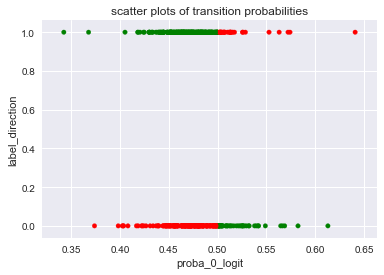

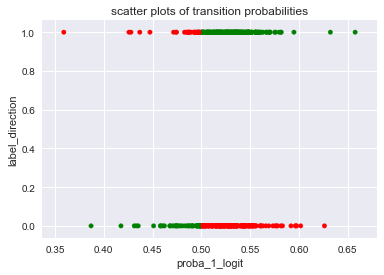

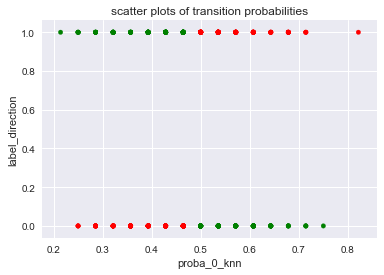

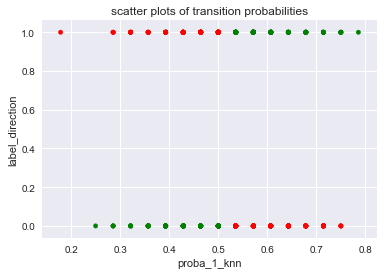

In [244]:
import plotly.express as px
for k in ['logit', 'knn']:
    for predict_label  in ['0', '1']:
        y_test_back_test_proba = y_test_back_test[['proba_' + str(predict_label) + '_' + str(k),'pos_' + str(k), 'label_direction']]
        y_test_back_test_proba['color_group'] = y_test_back_test_proba.apply(lambda x : 1 if x['pos_' + str(k)] == x['label_direction'] else 0, axis = 1)
#         px.scatter(y_test_back_test_proba, x='proba_' + str(predict_label) + '_' + str(k), y='label_direction', \
#                    color = 'color_group', title = 'scatter plots for transition probabilities')
        y_test_back_test_proba.plot.scatter(x='proba_' + str(predict_label) + '_' + str(k), \
                                            y='label_direction', \
                                            c = y_test_back_test_proba['color_group'].map({0:'red', 1: 'green'}), \
                                            title = 'scatter plots of transition probabilities')

#### Task B.3b Strategy plots - allocation 100% and Kelly optimal fraction
Let's 1st check the strategy plot of the allocation is 100% 

In [185]:
y_test_back_test[['strat_logit', 'strat_knn', 'label_return']].cumsum().apply(np.exp).\
iplot(title = 'Simulation of strategy value for ticker XLNX compared to Buy and Hold - allocation 100%')

Then we check the strategy plot of using the Kelly Criterion (threshold 0.52) to allocate into predicted position and cash

In [262]:
y_test_back_test[['kelly_strat_logit', 'kelly_strat_knn', 'label_return']].cumsum().apply(np.exp).\
iplot(title = 'Simulation of kelly strategy value for ticker XLNX compared to Buy and Hold - threshold 0.52')

The fractional allocation reduces the risk, strategy's backtesting with kelly shows steadly increasing return with low volatility. It performs not well when the equity has a high drift.

### Task B.4 mathematical
**mathematical** Find the way to present the pdf of Normal distribution in the form below, state explicitly what are $a(x); b(\mu), c(\mu), d(x)$
$$f(x;\mu) = e^{a(x)b(\mu)+c(\mu)+d(x)}$$

pdf expression not provided, you have to identify places of $x$, $\mu$ in it.

The pdf of normal distribution is parametrized by $\mu$ and $\sigma$, giving the expression $$f(x;\mu,\sigma) = \frac{1}{\sigma \sqrt{2\pi}} e^{-{\frac{1}{2}}{(\frac{x-\mu}{\sigma})}^2}$$

Let $f(x; \mu, \sigma) = f(x; u)$, $\sigma = \frac{1}{\sqrt{2\pi}}$; subsitute $\sigma = \frac{1}{\sqrt{2\pi}}$ into the expression $f(x;\mu,\sigma)$, we get $$f(x;\mu,\sigma) = f(x;\mu) = e^{-\pi(x-\mu)^2} = e^{-\pi x^2 + 2\pi \mu x - \pi \mu^2}$$
Given the form $f(x;\mu) = e^{a(x)b(\mu)+c(\mu)+d(x)}$, we have $$e^{a(x)b(\mu)+c(\mu)+d(x)} = e^{-\pi x^2 + 2\pi \mu x - \pi \mu^2}$$

Therefore,
$$
\begin{align} 
a(x) & = 2\pi x\\
b(\mu) & = \mu \\
c(\mu) & = -\pi \mu^2 \\
d(x) & = -\pi x^2
\end{align}
$$

# Appendix

## Assets' object file dump
The above result output only shows 1 equity, the remaining prepared data, fitted model, and output metric (plot included) are dumpped into pickle files below. You can check at the project directory.

**Note**: The feature selection and model tunning (GridSearchCV) don't include in the Class Asset since the time takes too long.

**<font color='red'>Issue:</font>** When rendering unplicked objects' plot output in the notebook, it shows object NoneType error, similar issue as reported below:

https://github.com/ipython/ipykernel/issues/231

I'm still investigating, and see if there's other trade-off approaches to store figure objects.

In [263]:
import pickle
pickle.dump(assets['XLNX'], open("asset_xlnx.pkl", "wb" ) )
pickle.dump(assets['TXN'], open("asset_txn.pkl", "wb" ) )

In [290]:
txn = pickle.load(open("asset_xlnx.pkl", "rb" ))

In [291]:
print(txn.symbol)
print(txn.start_date)
print(txn.end_date)
txn.df.head(1)

XLNX
2010-01-10
2020-01-10


,mom5_lag_1,std5_lag_1,ma5_lag_1,ewma5_lag_1,mom13_lag_1,std13_lag_1,ma13_lag_1,ewma13_lag_1,mom34_lag_1,std34_lag_1,...,return_lag_3,return_lag_4,return_lag_5,return_lag_6,return_lag_7,change_open_lag_1,change_high_lag_1,change_low_lag_1,label_return,label_direction
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-07,0.003215,0.024821,24.642,24.743479,0.007264,0.023665,24.296154,24.589392,-0.092033,0.022816,...,0.031304,-0.022752,-0.017434,0.045219,0.001684,0.009685,0.003909,0.006873,-0.02721,0


In [292]:
txn.y_test_predict_df.head(5)

,y_logit,y_nb,y_svm,y_knn,y_rf
0,0,1,1,1,1
1,1,1,1,0,1
2,1,1,1,1,1
3,1,1,1,0,1
4,1,1,1,1,1


In [293]:
pd.concat(txn.test_confusion_matrix_dict.values(), ignore_index=False)

,tn,fp,fn,tp,precision,recall,f1
model_name,,,,,,,
y_logit,95,133,96,160,0.546075,0.625000,0.582878
y_nb,170,58,189,67,0.536000,0.261719,0.351706
y_svm,17,211,16,240,0.532151,0.937500,0.678925
y_knn,124,104,150,106,0.504762,0.414062,0.454936
y_rf,150,78,161,95,0.549133,0.371094,0.442890


In [294]:
test = txn.test_auc_plot_dict
#test

## The tasks again on FOREX

The poor accuracy and recall in the selected equities make me think if the result stay the sames on other assets. I've tried lots of assets, and found out the performance on FOREX is relativly high.

In [333]:
fx_usdgbp = AssetData('USDGBP=X', start_date='2010-01-10', \
                               end_date='2020-01-10', if_bin=False, \
                               y_column = 'direction', y_return = 'return')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [334]:
print(fx_usdgbp.symbol)
fx_usdgbp.df.head(3)

USDGBP=X


,mom5_lag_1,std5_lag_1,ma5_lag_1,ewma5_lag_1,mom13_lag_1,std13_lag_1,ma13_lag_1,ewma13_lag_1,mom34_lag_1,std34_lag_1,...,return_lag_3,return_lag_4,return_lag_5,return_lag_6,return_lag_7,change_open_lag_1,change_high_lag_1,change_low_lag_1,label_return,label_direction
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-01,-0.007781,0.007402,0.691248,0.690584,0.021692,0.008330,0.691814,0.688021,0.058928,0.007097,...,-0.012200,0.002160,-0.000418,0.004984,-0.009196,0.007092,0.000650,0.003849,-0.009939,0
2010-06-02,-0.017183,0.008214,0.688864,0.687656,-0.003624,0.007834,0.691623,0.687132,0.054895,0.007253,...,0.007413,-0.012200,0.002160,-0.000418,0.004984,-0.005027,-0.000967,-0.011547,0.001158,1
2010-06-03,-0.018167,0.008053,0.686338,0.685967,-0.007647,0.007676,0.691218,0.686483,0.055660,0.007250,...,-0.004766,0.007413,-0.012200,0.002160,-0.000418,-0.009735,-0.007831,-0.003391,0.001098,1


In [335]:
pd.concat(fx_usdgbp.test_confusion_matrix_dict.values(), ignore_index=False)

,tn,fp,fn,tp,precision,recall,f1
model_name,,,,,,,
y_logit,173,66,78,184,0.736000,0.702290,0.718750
y_nb,228,11,246,16,0.592593,0.061069,0.110727
y_svm,173,66,101,161,0.709251,0.614504,0.658487
y_knn,162,77,154,108,0.583784,0.412214,0.483221
y_rf,151,88,80,182,0.674074,0.694656,0.684211


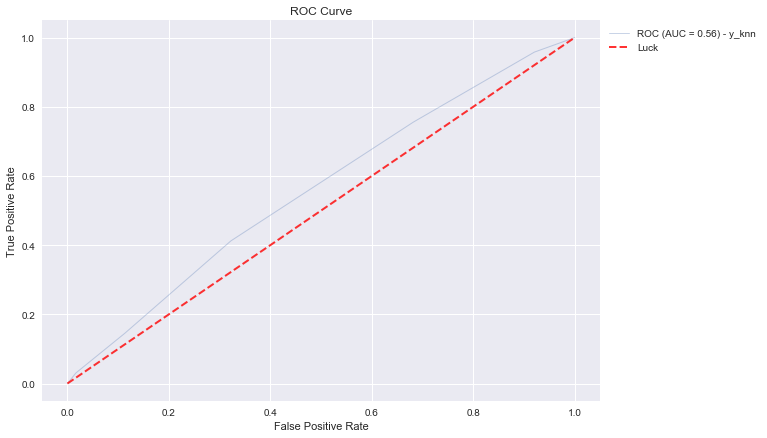

In [345]:
fx_usdgbp.test_auc_plot_dict['y_logit']
#fx_usdgbp.test_auc_plot_dict['y_nb']
#fx_usdgbp.test_auc_plot_dict['y_knn']
#fx_usdgbp.test_auc_plot_dict['y_rf']

# References

Python for Finance: Mastering Data-Driven Finance

Advances in Financial Machine Learning

https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/07.%20Cross%20Validation%20in%20Finance.ipynb

https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py

https://github.com/yhilpisch/py4fi2nd

https://en.wikipedia.org/wiki/Probability_density_function#Formal_definition

https://stats.stackexchange.com/questions/5728/reducing-false-positive-rate

https://catboost.ai/